# Deep Learning Lab
#### Name :- Gaurav Prakash Lute 
#### Roll No :- MT2313

# All Library

In [1]:
import numpy as np
import random 
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression,LogisticRegression,Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split,GridSearchCV)
import torch.nn as nn

C:\Users\ranig\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ranig\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Torch-Specific Imports 
torchmetrics metrics to evaluate performance when fitting a model.


In [2]:
from torchmetrics import (MeanAbsoluteError,
R2Score)
from torchinfo import summary
from torchvision.io import read_image

In [3]:
from pytorch_lightning import seed_everything
import torch
# Set the seed
seed_everything(0, workers=True)

# Enable deterministic algorithms
torch.use_deterministic_algorithms(True, warn_only=True)


Seed set to 0


In [4]:
#We will use several datasets shipped with torchvision for our examples: a pretrained network for
#image classification, as well as some transforms used for preprocessing

from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,ResNet50_Weights)
from torchvision.transforms import (Resize,Normalize,CenterCrop,ToTensor)

In [5]:
 from ISLP.torch import (SimpleDataModule,SimpleModule,ErrorTracker,rec_num_workers)

In [6]:
from ISLP.torch.imdb import (load_lookup,load_tensor,load_sparse,load_sequential)

In [7]:
from glob import glob
import json

# Single Layer Network on Hitters Data

1) We will fit the two linear models on Hatters data. Two linear model is Least Square and lasso.
2) Applying general process follow to fitting model like data loading split data train and test then select the model and fitting and fiding the accuracy and which one is best as describe below.
3) Comparison we will use mean absolute error on a validation datasets.
4) Setup model matrix and respose. We use the sklearn to fit the Lasso Model also fit the linear regression using sklearn to make easier the comparison. 
5) Now split the data into test and training data.
6) Fit the linear model and estimate the test error is 259.7152 
7) Now we fit lasso using sklearn, we first normalize the features using StandardScaler() transform then fit Lasso.also we create grid of $\lambda$.LASSO regression,  also known as L1 regularization, is a popular technique used in statistical modeling and machine learning to estimate the relationships between variables and make predictions.  
8) Now perform cross-validation using sequence of $\lambda$ values. Cross-Validation is a statistical method of evaluating and comparing learning algorithms by dividing data into two segments.9)We take out the lasso model with best cross-validated mean absolute error is 257.2382. 
9) To fit the neural network
10) Defining a procedure neural network model class HittersModel that come into from PyTorch's nn.Module
11) Creating sample of the model and  assign to it
12) Using the super() function to access methods of the base class
13) Defining the forward method to describe the mapping implemented by the module
14) Using the torchinfo package to summarize the model's architecture and parameters
15) Preparing data for training by converting it to tensors and creating a Dataset and DataLoader
16) Setting up a PyTorch Lightning module to control the training process
17) Logging results using a CSVLogger
18) Training the model using a Trainer object
19) Evaluating the model's performance on test data
20) Plotting the mean absolute error (MAE) as a function of the number of epochs


In [8]:
# load the hitters datasests
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

In [9]:
Hitters.shape

(263, 20)

In [10]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

In [11]:
# split the datasets in train and test 
(X_train,X_test,Y_train,Y_test) = train_test_split(X,Y,test_size=1/3,random_state=1)

In [ ]:
# linear models

In [12]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.71528833146294

In [13]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
('lasso', lasso)])

In [14]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))* lam_max}

In [15]:
cv = KFold(10,shuffle=True,random_state=1)
grid = GridSearchCV(lasso,param_grid,cv=cv,scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

In [16]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.23820107995

In [17]:
from torch import nn
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel , self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [18]:

hit_model = HittersModel(X.shape[1])


In [19]:
summary(hit_model,input_size=X_train.shape,col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [20]:
from torch.utils.data import TensorDataset


In [21]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

In [22]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

In [23]:
max_num_workers = rec_num_workers()

In [24]:
hit_dm = SimpleDataModule(hit_train,hit_test,batch_size=32,num_workers=min(4, max_num_workers),validation=hit_test)

In [25]:
#hat simply record the value of the loss function and any additional metrics at the end of each epoch
hit_module = SimpleModule.regression(hit_model,metrics={'mae':MeanAbsoluteError()})

In [26]:
from pytorch_lightning.loggers import CSVLogger

In [27]:
hit_logger = CSVLogger('logs', name='hitters')

In [28]:
from pytorch_lightning import Trainer
hit_trainer = Trainer(deterministic=True,max_epochs=50,log_every_n_steps=5,logger=hit_logger,callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.


In [29]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      104098.5546875       │
│         test_mae          │    229.50112915039062     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 104098.5546875, 'test_mae': 229.50112915039062}]

In [30]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [31]:
#  Since we will produce similar plots
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    columns = ['train_' + col + '_epoch', 'valid_' + col]
    colors = ['black', 'red']
    labels = [training_legend, valid_legend]

    for column, color, label in zip(columns, colors, labels):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)

    ax.set_xlabel('Epoch', fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    return ax





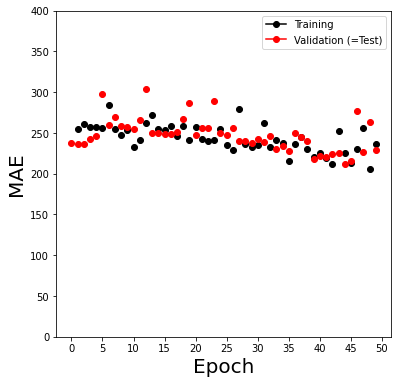

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming summary_plot and hit_results are defined
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')

# Set axis limits and ticks
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int))

plt.show()


In [33]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5011, grad_fn=<MeanBackward0>)

In [34]:
# clean up all running process 
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)

# Multilayer Network on the MNIST Digit Data

1) This code demonstrate two different neural network architechture:
- **Multilayer Perceptron** and  **Multiclass Logistic Regression**
  
2)  **Multilayer Perceptron**
- **Input Size**  Each image in MNIST data is of size 28x28 pixels, which means the input layer has 784 neurons (28*28=784).
- The images are flattened into a 1D vector before passing into the neural network.
- **Layer1**
- There are 784 neurons input in this layer.The number of neurons is 256. Above layer apply activation function is ReLU that introduce nonlinearity by adjust to zero out negative values.
- Dropout is applied to randomly turn off 40% of the neurons during the training.Which helps to stop overfitting.
- **Layer2**
- There are 256 neuron input in this layer. The number of neuron is 128. This layer apply activation function is ReLU.
- Droup is similar as first layer almost 30%.
- **Output Layer**
- There are 128 neurons from the second layer. The number of neuron is 10.
- The out layer has no activation function in the block,during the training and testing, this tipically paired Softmax function. Which converts 10 output value into probabilities that sum is 1.

3) **Multi-Class Logistic Regression(MLR)**
- This model is fully connected layer with no hidden layer.
- **Input Layer**
- The input layer is 1d vector input is flatten of 784 pixels.
- **Output Layer**
- There are 784 pixels are directly connected to the output layer.
- Number of neurons is 10. One for each possible to (0-9).
- Softmax function is used in the loss function to conver output score shows in probanilities.

4) **Model Training and Evaluation**
- The model trained at 30 epochs using deterministic trainer.
- After training, the models are evaluated on the test dataset and result are plotted.

In [35]:
(mnist_train,
mnist_test) = [MNIST(root='data',
                     train=train,
                     download=True,
                     transform=ToTensor())
                for train in [True, False]]
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [36]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)

In [37]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [38]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10))
    def forward(self, x):
        return self._forward(x)

In [39]:
mnist_model = MNISTModel()

In [40]:
mnist_model(X_).size()

torch.Size([256, 10])

In [41]:
summary(mnist_model,
        input_data=X_,
        col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [42]:
from ISLP.torch import SimpleModule
from pytorch_lightning.loggers import CSVLogger

# Define the number of classes for MNIST
num_classes = 10

# Initialize the classification module with the number of classes
mnist_module = SimpleModule.classification(mnist_model, num_classes=num_classes)

# Initialize the CSVLogger
mnist_logger = CSVLogger('logs', name='MNIST')

"""from ISLP.torch import  SimpleModule
mnist_module = SimpleModule.classification(mnist_model)
mnist_logger = CSVLogger('logs', name='MNIST')"""

"from ISLP.torch import  SimpleModule\nmnist_module = SimpleModule.classification(mnist_model)\nmnist_logger = CSVLogger('logs', name='MNIST')"

In [43]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [44]:
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


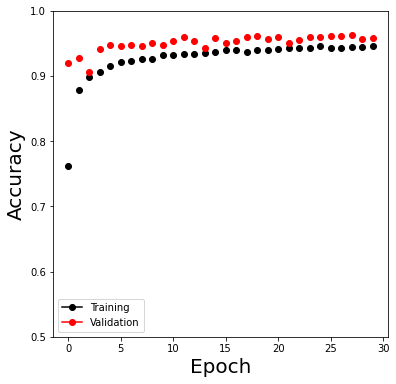

In [45]:
mnist_results = pd.read_csv(mnist_logger.experiment.
metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [46]:
mnist_trainer.test(mnist_module,datamodule=mnist_dm)

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9603000283241272     │
│         test_loss         │    0.16797153651714325    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.16797153651714325, 'test_accuracy': 0.9603000283241272}]

In [47]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),nn.Linear(784, 10))
        
    def forward(self, x):
        return self.linear(x)
    
mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [48]:
mlr_trainer = Trainer(deterministic=True,max_epochs=30,callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


In [49]:
mlr_trainer.test(mlr_module,datamodule=mnist_dm)

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.90829998254776      │
│         test_loss         │    0.35908135771751404    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.35908135771751404, 'test_accuracy': 0.90829998254776}]

In [50]:
# cleanup
del(mnist_test,mnist_train,mnist_model,mnist_dm,mnist_trainer,mnist_module,mnist_results,mlr_model,mlr_module,mlr_trainer)

# Convolutional Neural Networks

1) There are two different CNN models to clasify images.
- The first model is custom **CNN model** and the second is **pretrainedResNet-50**

2) **Custom Convolution Neural Network** - CIFARModel
- The CNN is the BuildingBlock class, represent a block with three layers:
- **Convolution Layer** The input image to detect features such as edges, textures, or patterns. The use filter size is 3x3
- **ReLU Activation** A Rectified linear unit introduce non-linearity, to network to learn complex pattern.
- **Max Pooling** Maxpooling is reduce the spacial diamension of the feature maps, which helps to reduce complexity.

3) **CIFARModel class**This class build sequence of BuildingBlock layer
- There are 3 input channels(RGB image)
- Also 4 convolutional Blocks. Each block applies a convolution, ReLU and maxpooling operation.
- The final feature map is flatten layer that means 1D layer.
- The connected layers are two, there are 50% neurons randomly away from during training to remove overfitting.In linear Layer has 512 neurons nad applies activation function is ReLU, and second is number of 100 neurons
- The model use 4 convolution layer followed by 2 fully connected layers to predict the class for each image.
- **Training and Evaluation** The model train for 30 epochs using the trainer class.
- **Evaluating the model** showing the model performance across epochs

4) **Pretrained ResNet-50**
- The images are resized 232x232 and the center-cropped to 224x224. This images is normalizes using mean and standard deviation.
- The ResNet50 model is loadede with pretrained weights. The model architechture is complex, with the 50 layers and residual connections.
- **prediction** The model that predict class of probabilities for the new images, and the top 3 class prdictions with their probabilities for each image.

In [51]:
# required liberies 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import RMSprop
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [52]:
(cifar_train, cifar_test) = [CIFAR100(root="data", train=train, download=True) for train in [True, False]]

Files already downloaded and verified
Files already downloaded and verified


In [53]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,torch.tensor(cifar_test.targets))

In [54]:
cifar_dm = SimpleDataModule(cifar_train,cifar_test,validation=0.2,num_workers=max_num_workers,batch_size=128)

In [55]:
# we  show the shape of the data sets 
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


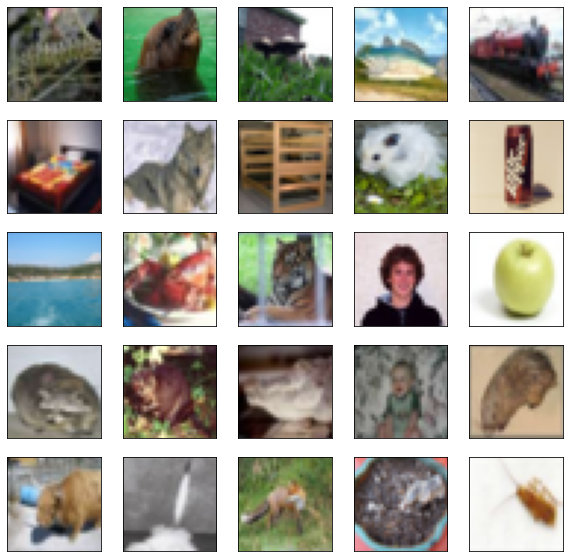

In [56]:
fig,axes=subplots(5,5,figsize=(10,10))
rng=np.random.default_rng(4)
indices=rng.choice(np.arange(len(cifar_train)),25,replace=False).reshape((5,5))

for i in range(5):
    for j in range(5):
        idx=indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],[1,2,0]), interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [57]:
class BuildingBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                             out_channels=out_channels,
                             kernel_size=(3,3),
                             padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

In [58]:
class CIFARModel(nn.Module):

    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32), (32, 64),
                (64,128),(128, 256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                   for in_, out_ in sizes])
        self.output = nn.Sequential(nn.Dropout(0.5),
                                   nn.Linear(2*2*256, 512),
                                   nn.ReLU(), nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

In [59]:
# We build the model and look at the summary
cifar_model = CIFARModel()
summary(cifar_model, input_data = X_, col_names = ['input_size', 'output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [60]:
cifar_optimizer = RMSprop(cifar_model.parameters(),lr = 0.01,)
cifar_module = SimpleModule.classification(cifar_model, 
                                           optimizer = cifar_optimizer, 
                                           num_classes=100)
cifar_logger = CSVLogger('logs', name='CIFAR100')

In [61]:
cifar_trainer = Trainer(deterministic=True,
                       max_epochs=30, logger=cifar_logger,
                       callbacks =[ErrorTracker()])
cifar_trainer.fit(cifar_module, datamodule=cifar_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


(0.0, 1.0)

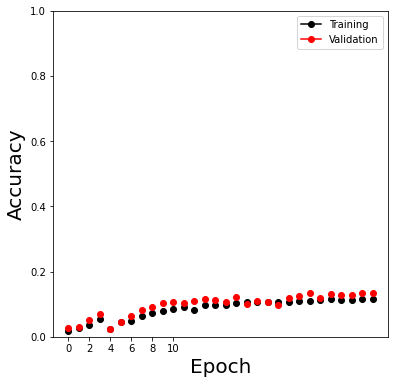

In [62]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])

In [63]:
cifar_trainer.test(cifar_module,datamodule=cifar_dm)

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.13189999759197235    │
│         test_loss         │    3.7288079261779785     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.7288079261779785, 'test_accuracy': 0.13189999759197235}]

In [ ]:
# Hardware Acceleration

In [64]:
try:
    for name,metric in cifar_module.metrics.item():
        cifar_module.metirics[name]=metric.to('mps')
    cifar_trainer_mps = Trainer(accelerator='mps',deterministic=True,max_epochs=30)
    cifar_trainer_mps.fit(cifar_module,datamodule=cifar_dm)
    cifar_trainer_mps.test(cifar_module,datamodule=cifar_dm)
except:
    pass

In [ ]:
# Using Pretrained CNN Models


In [65]:
resize=Resize((232,232), antialias=True)
crop=CenterCrop(224)
normalize=Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('book_images/*')  if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])
imgs = normalize(imgs)
imgs.size()


torch.Size([6, 3, 224, 224])

In [66]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,input_data=imgs,col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [67]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [68]:
img_preds = resnet_model(imgs)

In [69]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

In [70]:
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in labs.items()], columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()


In [71]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: book_images\10_10a.jpg
            label      prob
0        flamingo  0.609514
1       spoonbill  0.013586
2  American_egret  0.002132
Image: book_images\10_10b.jpg
            label      prob
0            kite  0.453834
1  great_grey_owl  0.015914
2             jay  0.012210
Image: book_images\10_10c.jpg
            label      prob
0            kite  0.184717
1           robin  0.084018
2  great_grey_owl  0.061267
Image: book_images\10_10d.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097195
2  Tibetan_terrier  0.032819
Image: book_images\10_10e.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578
Image: book_images\10_10f.jpg
      label      prob
0   jacamar  0.297500
1     macaw  0.068107
2  lorikeet  0.051104


In [72]:
# r usual cleanup
del(cifar_test,cifar_train,cifar_dm,cifar_module,cifar_logger,cifar_optimizer,cifar_trainer)

# IMDB Document Classification

1) **IMDB Model** This simple fully connected Neural Network for binnary classification of IMDB movie reviews.
- **Input Layer** The input layer receives a feature vector, size is depend on the data.
- **Hidden Layer** This hidden layer has 16 neurons. This layer are fully connected to previous and next layer.The ReLU activation activation function is used.
- **Output Layer** The final reduce the output to a single value.
- **Forward Pass** The input passes through the two hidden layers applies a linear transformation follows,the output layer produce a single value.

2) **Lasso logistics Regression** The model which controlling the model complexity.
- **Logistic Regression** Logistic regression is a linear model that predicts the probability, the model uses a sigmoid function to output probabilities between 0 and 1.
- **L1 Regularization** L1 regularization adds a penalty based on the absolute values of the model coefficient, some coefficient shrink to zero, the selecting only the most important feature.A higher penalty results in more coefficient being reduced to zero, the model more interpretable and less to overfitting.
- The accuracy is plotted to visualize how regularization impacts model generalization and feature selection.
- The neural network is more flexible but harder to interprete than the lasso. 

In [73]:
(imdb_seq_train,imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]

C:\Users\ranig\anaconda3\lib\site-packages\ISLP\torch\imdb.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  S_test) = [torch.load(_get_imdb(f'IMDB_{r}', root))


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468])

In [74]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

"<START> this film was just brilliant casting location scenery story direction everyone's"

In [75]:
max_num_workers=10
(imdb_train,imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,imdb_test,validation=2000,num_workers=min(6, max_num_workers),batch_size=512)

C:\Users\ranig\anaconda3\lib\site-packages\ISLP\torch\imdb.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test, X_train = [torch.load(_get_imdb(f'IMDB_{r}', root))


In [76]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
    def forward(self, x):
        val = x
        for _map in [self.dense1,self.activation,self.dense2,self.activation,self.output]:
            val = _map(val)
        return torch.flatten(val)


        


In [77]:
# model and look at a summary.

imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,input_size=imdb_test.tensors[0].size(),col_names=['input_size','output_size','num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (G): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [78]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(imdb_model,optimizer=imdb_optimizer)


In [79]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,max_epochs=30,logger=imdb_logger,callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module,datamodule=imdb_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\ranig\anaconda3\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


In [80]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8538399934768677     │
│         test_loss         │    1.1410893201828003     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1410893201828003, 'test_accuracy': 0.8538399934768677}]

In [ ]:
# Comparison to Lasso

In [81]:
((X_train, Y_train),(X_valid, Y_valid),(X_test, Y_test)) = load_sparse(validation=2000,random_state=0,root='data/IMDB')


In [82]:
# we create a series of 50 values for the lasso reguralization parameter .
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),np.log(1e-4), 50))

In [83]:
logit = LogisticRegression(penalty='l1',C=1/lam_max,solver='liblinear',warm_start=True,fit_intercept=True)

In [84]:
coefs = []
intercepts = []
for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [87]:
# coefficient and intercepts have an extraneous dimension which can be removed by thenp.squeeze() function.
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

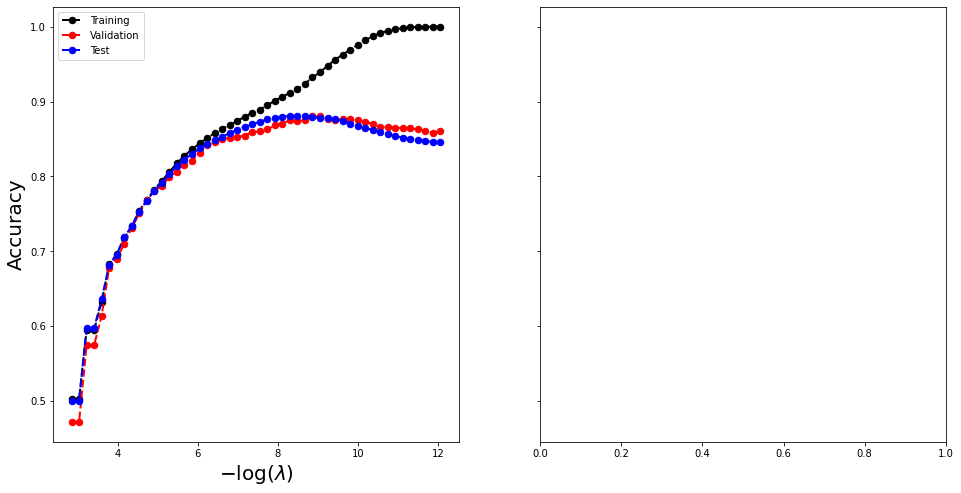

In [98]:
# make a plot to compare our neural network results with the lasso.

#%%capture output
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

for ((X_, Y_), data_, color) in zip([(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)],
                                    ['Training', 'Validation', 'Test'],
                                    ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None, :]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]), accuracy_, '.--', color=color, markersize=13, linewidth=2, label=data_)

axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)
plt.show()

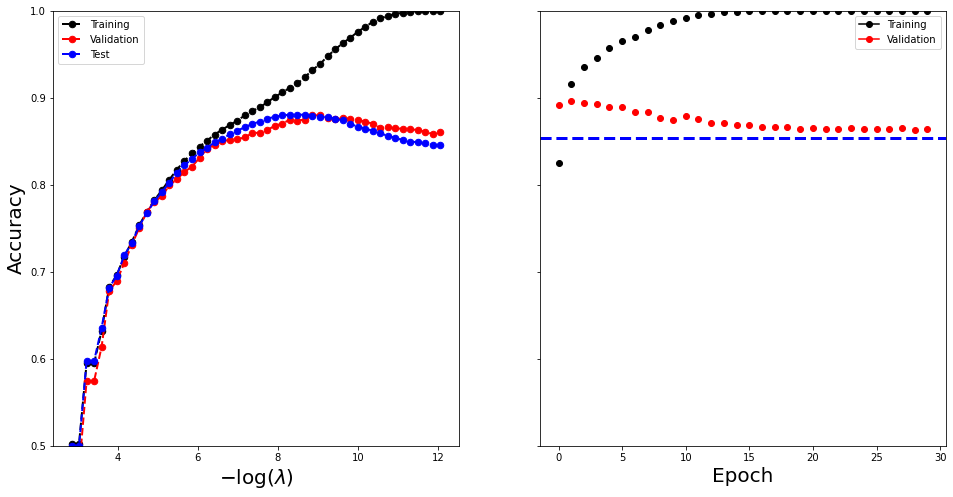

In [99]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results, axes[1], col='accuracy', ylabel='Accuracy')


axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1])

# Plot horizontal line for test accuracy
axes[1].axhline(test_results[0]['test_accuracy'], color='blue', linestyle='--', linewidth=3)
fig

The graphs indicate that the accuracy of the Lasso logistic regression model reaches a peak of approximately 0.88, which is similar to the accuracy achieved by the neural network model.

In [101]:
# delete the specific variables
del(imdb_model,imdb_trainer,imdb_logger,imdb_dm,imdb_train,imdb_test)

# Recurrent Neural Networks

1) **IMDB Dataset** This dataset typically contains movie reviews labelled as positive or negative.
2) **LSTM Model** This neural network model is an LSTM network to handle sequential data
- **Embedding Layer**
- The embadding layer maps these indices to dense vectors in a lower-dimensional space, allowing the model to learn relationships between words based on their vector representation.
- The embedding size is set to 32, meaning each will be represented by a 32-dimension vector.
- **LSTM Layer**
- LSTM is a type of RNN that can process and store information over multiple time steps.
- The input size of the embeddings is 32
- The number of hidden units is 32
- **Linear Dense Layer**
- The output of the LSTM passes through this fully connected layers to perform binary classification.
- This connectivity allows the layer to learn complex relationships between the input and output data.

In [102]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train,imdb_seq_test,validation=2000,batch_size=300,num_workers=min(6, max_num_workers))

In [103]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, batch_first=True)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        x = self.embedding(x)
        val, (h_n, c_n) = self.lstm(x)
        return torch.flatten(self.dense(val[:, -1]))

In [104]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,input_data=imdb_seq_train.tensors[0][:10],col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (M): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [105]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

In [106]:
lstm_trainer = Trainer(deterministic=True,max_epochs=20,logger=lstm_logger,callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module,datamodule=imdb_seq_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


In [107]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8390799760818481     │
│         test_loss         │    0.7581205368041992     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7581205368041992, 'test_accuracy': 0.8390799760818481}]

(0.5, 1.0)

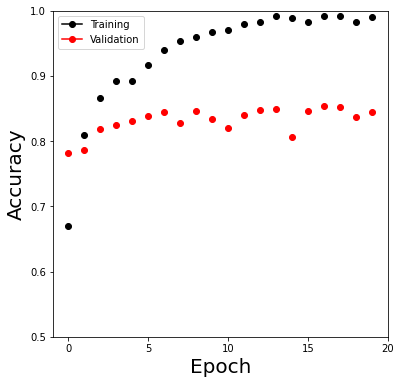

In [108]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

summary_plot(lstm_results, ax, col='accuracy', ylabel='Accuracy')

ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylim([0.5, 1])

In [109]:
del(lstm_model,lstm_trainer,lstm_logger,imdb_seq_dm,imdb_seq_train,imdb_seq_test)


# Time Series Prediction

Linear Regression Model\
-A simple linear regression model is trained on the lagged features to predict log_volume.\
-This model is trained without considering the day_of_week.\
-Categorical features for the day of week are merged into feature set and model is trained again.\
-The calculate the R2score on both training and testing datasets, which measures well the model explain the variance of the target variable.\
-Recurrent Neural Network(RNN) RNN is to capture temporal dependencies in the data.\
-Lagged features are grouped into sequence of shape where 5 is the number of time steps and 3 is the number of features.
-RNN(NYSEModel)\
-There are the 3 number of features. The RNN has 12 hidden units, regularization using to prevent overfitting\
-The last state of RNN is passed to a fully connected dense layer, which produce sing output.\
-The model is trained using RMSprop and performance measure in R2Score.\
-A Nonlinear Autoregressive Model This Model Introduce nonlinearity through fully connected layer\
-This model uses a feeedforward neural network, In the input tensor is flatted to a vector, it better capture complex relationship in the data.\
-A dense layer with 32 units and a ReLU activation function is used\
-A droupout layer with 50% dropout rate for regularization.\
-A dense layer with 1 output, which is predicted log volume\
-The model is simple but still allows for capturing non linear relationships in the data.\


In [110]:
NYSE = load_data('NYSE')

cols = ['DJ_return', 'log_volume', 'log_volatility']

X = pd.DataFrame(StandardScaler(with_mean=True, with_std=True).fit_transform(NYSE[cols]),columns=NYSE[cols].columns,index=NYSE.index)

In [111]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)

X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [112]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [113]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.41289129385625223

In [114]:
X_day = pd.merge(X,pd.get_dummies(NYSE['day_of_week']),on='date')

In [115]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])


0.4595563133053274

In [116]:
ordered_cols = []
for lag in range(5, 0, -1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))

ordered_cols.extend(cols)  # Add the original columns to the end
ordered_cols.append('train')  # Add the 'train' column to the end

X = X.reindex(columns=ordered_cols)
print(X.columns)

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return',
       'log_volume', 'log_volatility', 'train'],
      dtype='object')


In [117]:
# reshape the data.
padding_needed = (15 - (X.size % 15)) % 15  # Calculate how much padding is needed
X_padded = np.pad(X.to_numpy(), (0, padding_needed), mode='constant')  # Pad with zeros
X_rnn = X_padded.reshape((-1, 5, 3))
X_rnn

array([[[-0.54982334,  0.17507497, -4.35707786],
        [ 0.90519995,  1.51729071, -2.52905765],
        [ 0.43481275,  2.28378937, -2.41803694],
        [-0.43139673,  0.93517558, -2.36652094],
        [ 0.04634026,  0.22477858, -2.5009701 ]],

       [[        nan,         nan,         nan],
        [        nan,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.90519995,  1.51729071, -2.52905765],
        [ 0.43481275,  2.28378937, -2.41803694],
        [-0.43139673,  0.93517558, -2.36652094],
        [ 0.04634026,  0.22477858, -2.5009701 ],
        [-1.30412619,  0.60591805, -1.366028  ]],

       ...,

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],


In [118]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:, -1]))
        return torch.flatten(val)

nyse_model = NYSEModel()

In [119]:
X_rnn_truncated = X_rnn[:train.shape[0]]  # Truncate X_rnn to match the train mask
Y_truncated = Y[:train.shape[0]]  # Truncate Y as well

datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn_truncated[mask].astype(np.float32))
    Y_t = torch.tensor(Y_truncated[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))

nyse_train, nyse_test = datasets


C:\Users\ranig\AppData\Local\Temp\ipykernel_5604\2810773207.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y_truncated[mask].astype(np.float32))
C:\Users\ranig\AppData\Local\Temp\ipykernel_5604\2810773207.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y_truncated[mask].astype(np.float32))


In [120]:
# inspect the summary

summary(nyse_model, input_data=X_rnn_t, col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (M): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [121]:
nyse_dm = SimpleDataModule(nyse_train,nyse_test,num_workers=min(4, max_num_workers),validation=nyse_test,batch_size=64)

In [122]:
#  We run some data through our model to be sure the sizes match up correctly
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [123]:
nyse_optimizer = torch.optim.RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(nyse_model, optimizer=nyse_optimizer, metrics={'r2': R2Score()})

In [124]:
# Fitting the model 
nyse_trainer = Trainer(deterministic=True,max_epochs=200,callbacks=[ErrorTracker()])

nyse_trainer.fit(nyse_module, datamodule=nyse_dm)
nyse_trainer.test(nyse_module, datamodule=nyse_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
│          test_r2          │            nan            │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': nan, 'test_r2': nan}]

In [125]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))

day_train, day_test = datasets

In [126]:
day_dm = SimpleDataModule(day_train,day_test,num_workers=min(4, max_num_workers),validation=day_test,batch_size=64)

In [127]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),nn.Linear(20, 32),nn.ReLU(),nn.Dropout(0.5),nn.Linear(32, 1))
    def forward(self, x):
         return torch.flatten(self._forward(x))

In [128]:
nl_model = NonLinearARModel()
nl_optimizer = torch.optim.RMSprop(nl_model.parameters(), lr=0.001)
nl_module = SimpleModule.regression(nl_model, optimizer=nl_optimizer, metrics={'r2': R2Score()})

In [129]:
nl_trainer = Trainer(deterministic=True, max_epochs=20, callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 705    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5668875575065613     │
│          test_r2          │    0.46199601888656616    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5668875575065613, 'test_r2': 0.46199601888656616}]

In [130]:
NYSE = load_data('NYSE')

cols = ['DJ_return', 'log_volume', 'log_volatility']

X = pd.DataFrame(StandardScaler(with_mean=True, with_std=True).fit_transform(NYSE[cols]),columns=NYSE[cols].columns,index=NYSE.index)


for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)

X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns


M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])


X_day = pd.merge(X,pd.get_dummies(NYSE['day_of_week']),on='date')


M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])


ordered_cols = []
for lag in range(5, 0, -1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))

ordered_cols.extend(cols)  # Add the original columns to the end
ordered_cols.append('train')  # Add the 'train' column to the end

X = X.reindex(columns=ordered_cols)
print(X.columns)


padding_needed = (15 - (X.size % 15)) % 15  # Calculate how much padding is needed
X_padded = np.pad(X.to_numpy(), (0, padding_needed), mode='constant')  # Pad with zeros
X_rnn = X_padded.reshape((-1, 5, 3))




class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:, -1]))
        return torch.flatten(val)

nyse_model = NYSEModel()




X_rnn_truncated = X_rnn[:train.shape[0]]  # Truncate X_rnn to match the train mask
Y_truncated = Y[:train.shape[0]]  # Truncate Y as well

datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn_truncated[mask].astype(np.float32))
    Y_t = torch.tensor(Y_truncated[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))

nyse_train, nyse_test = datasets



summary(nyse_model, input_data=X_rnn_t, col_names=['input_size', 'output_size', 'num_params'])


nyse_dm = SimpleDataModule(nyse_train,nyse_test,num_workers=min(4, max_num_workers),validation=nyse_test,batch_size=64)


for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break
        
        
nyse_optimizer = torch.optim.RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(nyse_model, optimizer=nyse_optimizer, metrics={'r2': R2Score()})    
        
        
nyse_trainer = Trainer(deterministic=True,max_epochs=200,callbacks=[ErrorTracker()])

nyse_trainer.fit(nyse_module, datamodule=nyse_dm)
nyse_trainer.test(nyse_module, datamodule=nyse_dm)        
        
        
        
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))

day_train, day_test = datasets    



day_dm = SimpleDataModule(day_train,day_test,num_workers=min(4, max_num_workers),validation=day_test,batch_size=64)



class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),nn.Linear(20, 32),nn.ReLU(),nn.Dropout(0.5),nn.Linear(32, 1))
    def forward(self, x):
         return torch.flatten(self._forward(x))


nl_model = NonLinearARModel()
nl_optimizer = torch.optim.RMSprop(nl_model.parameters(), lr=0.001)
nl_module = SimpleModule.regression(nl_model, optimizer=nl_optimizer, metrics={'r2': R2Score()})


nl_trainer = Trainer(deterministic=True, max_epochs=20, callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)



Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return',
       'log_volume', 'log_volatility', 'train'],
      dtype='object')


C:\Users\ranig\AppData\Local\Temp\ipykernel_5604\828021240.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y_truncated[mask].astype(np.float32))
C:\Users\ranig\AppData\Local\Temp\ipykernel_5604\828021240.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y_truncated[mask].astype(np.float32))


torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
│          test_r2          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 705    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5671318173408508     │
│          test_r2          │    0.46176421642303467    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5671318173408508, 'test_r2': 0.46176421642303467}]